## Basic Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [2]:
# bulding a mock datatset 
X, y = make_classification(n_samples = 1000, n_features = 100, 
                           n_informative = 11, n_redundant = 35)
groups = np.repeat(np.arange(10), 100) # creatng random groups

In [3]:
# defining a model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV

# we will use ColinearityRemover to discard redundant features
from jhn_ai.transformers import ColinearityRemover

cv = GroupKFold(n_splits = 5)

model = Pipeline([
    ('scaling', StandardScaler()),
    ('linear_fs', ColinearityRemover()),
    ('estimator', LogisticRegression(solver ='saga'))
])

param_grid = {
    'estimator__C': [.0001, .001, .01, .1],
    'estimator__penalty': ['l1','l2']
}

optimizer = GridSearchCV(model, param_grid, cv = cv)

In [4]:
from jhn_ai.evaluation import supervised_crossvalidation
# nested crossvalidation in one line
scores, rocs, _, _, _ = supervised_crossvalidation(optimizer, X, y, groups = groups, cv = cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.50s/it]


In [5]:
# major scores
scores.groupby('metric').agg(['mean','std'])

# scores contains major classification scores for each classification fold and each class.
# Thus, compared to sklearn cross_validate it computes also disaggregated class scores.
# In this case, our model work well, scores are stable and balanced between class 0 and 1 across all metrics. 

set               train                                        test            \
class                 0                     1                     0             
                   mean       std        mean       std        mean       std   
metric                                                                          
f1             0.822527  0.006629    0.828218  0.008461    0.794149  0.043908   
precision      0.838408  0.006025    0.813500  0.007472    0.805984  0.054495   
recall         0.807294  0.010437    0.843529  0.011854    0.783306  0.039811   
roc_auc_ovr    0.898559  0.005436    0.898559  0.005436    0.875700  0.024400   
support      400.800000  7.395945  399.200000  7.395945  100.200000  7.395945   

set                               
class                1            
                  mean       std  
metric                            
f1            0.800303  0.033389  
precision     0.789351  0.032637  
recall        0.812205  0.042692  
roc_auc_ovr   0.875700  0.024400  
support      99.800000  7.395945

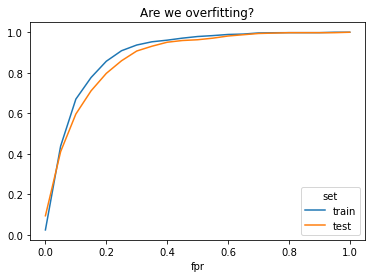

In [6]:
# ROCS in one line
# let's compare training and testing performance 
_ = rocs.groupby('fpr').mean().swaplevel(1,0, axis = 1)[1].plot(title = 'Are we overfitting?')

# similarly to scores, in rocs you will find FPR and TPR for each crossvalidation fold.
# you can tweak the resolution of ROC curves with fpr_interp kwarg in supervised_crossvalidation.

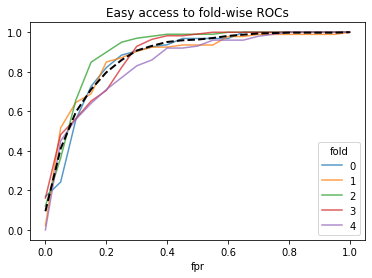

In [7]:
# in rocs you can eaily compute ROC for each fold to assess the stability of your model.
ax = rocs['test'][1].unstack().T.plot(title = 'Easy access to fold-wise ROCs', alpha = .75)
_ = rocs['test'][1].groupby('fpr').mean().plot(ax = ax, color = 'k', lw = 2, ls = '--')

# the black dotted line is the fold-average ROC 

As you can see, with jhn_ai we built, trained and evaluated a model with few lines of code.